In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

In [48]:
OUT_DIR = '/mnt/data/trader_sentiment_outputs'
os.makedirs(OUT_DIR, exist_ok=True)

In [49]:
hist_path = r'C:\Users\ksuya\Downloads\historical_data.csv'
fg_path = r'C:\Users\ksuya\Downloads\fear_greed_index.csv'



hist = pd.read_csv(hist_path, low_memory=False)
fg = pd.read_csv(fg_path, low_memory=False)


print('historical rows,cols:', hist.shape)
print('fear/greed rows,cols:', fg.shape)

historical rows,cols: (211224, 16)
fear/greed rows,cols: (2644, 4)


In [50]:
def find_col(df, possible_names):
    for col in df.columns:
        for name in possible_names:
            if name.lower() in col.lower():
                return col
    return None

# Helper function for converting to datetime
def to_datetime_safe(series):
    try:
        return pd.to_datetime(series, errors='coerce')
    except:
        return series
# Helper function to find columns dynamically
def find_col(df, possible_names):
    for col in df.columns:
        for name in possible_names:
            if name.lower() in col.lower():
                return col
    return None

# Helper function for converting to datetime
def to_datetime_safe(series):
    try:
        return pd.to_datetime(series, errors='coerce')
    except:
        return series
# Detect Account Column
col_account = find_col(hist, ['account','user','trader','client','customer'])

# Detect Price Column
col_price = find_col(hist, ['price','rate','value','amount'])

print(f"Account Column: {col_account}, Price Column: {col_price}")


Account Column: Account, Price Column: Execution Price


In [51]:
#3) Basic cleaning & column discovery
col_size = find_col(hist, ['size','qty','quantity','size tokens'])
col_side = find_col(hist, ['side','direction'])
col_time = find_col(hist, ['time','timestamp','date'])
col_closedpnl = find_col(hist, ['closedpnl','closed pnl','pnl','closed_pnl','closedPnL'])
col_leverage = find_col(hist, ['leverage','lev'])
col_symbol = find_col(hist, ['symbol','pair'])


print('Detected columns mapping:')
print('account:', col_account)
print('price:', col_price)
print('size:', col_size)
print('side:', col_side)
print('time:', col_time)
print('closedpnl:', col_closedpnl)
print('leverage:', col_leverage)
print('symbol:', col_symbol)


# Coerce types
for c in [col_price, col_size, col_closedpnl, col_leverage]:
    if c and c in hist.columns:
        hist[c] = pd.to_numeric(hist[c], errors='coerce')


# parse time
if col_time and col_time in hist.columns:
    hist['trade_time'] = pd.to_datetime(hist[col_time], errors='coerce')
else:
    hist['trade_time'] = pd.NaT


hist['trade_date'] = hist['trade_time'].dt.date


# Fear/Greed: find date, numeric, class
fg_date_col = find_col(fg, ['date','timestamp'])
fg_value_col = find_col(fg, ['value','index','score','fear','greed'])
fg_class_col = find_col(fg, ['classification','classification','label','sentiment'])


if fg_date_col:
    fg['fg_date'] = pd.to_datetime(fg[fg_date_col], errors='coerce').dt.date
else:
    fg['fg_date'] = pd.NaT


if fg_value_col:
    fg['fg_value'] = pd.to_numeric(fg[fg_value_col], errors='coerce')
else:
    fg['fg_value'] = np.nan


if fg_class_col:
    fg['classification'] = fg[fg_class_col].astype(str)
else:
# simple mapping of numeric -> class
    def map_fg(v):
        if pd.isna(v): return np.nan
        if v <= 25: return 'Fear'
        if v <= 50: return 'Neutral'
        if v <= 75: return 'Greed'
        return 'Extreme Greed'
    fg['classification'] = fg['fg_value'].apply(map_fg)

Detected columns mapping:
account: Account
price: Execution Price
size: Size Tokens
side: Side
time: Timestamp IST
closedpnl: Closed PnL
leverage: None
symbol: None


In [52]:
agg_cols = {}
if col_closedpnl: agg_cols['closedpnl_sum'] = (col_closedpnl, 'sum')
if col_closedpnl: agg_cols['closedpnl_mean'] = (col_closedpnl, 'mean')
if col_closedpnl: agg_cols['closedpnl_med'] = (col_closedpnl, 'median')
if col_size: agg_cols['volume'] = (col_size, 'sum')
if col_account: agg_cols['unique_accounts'] = (col_account, lambda x: x.nunique())
if col_leverage: agg_cols['avg_leverage'] = (col_leverage, 'mean')


if hist['trade_date'].notna().sum() > 0:
    daily = hist.groupby('trade_date').agg(**{k:(v[0], v[1]) for k,v in agg_cols.items()}).reset_index().rename(columns={'trade_date':'date'})
else:
    daily = pd.DataFrame()


# win rate per day
if col_closedpnl:
    hist['is_win'] = hist[col_closedpnl] > 0
    winrate = hist.groupby('trade_date')['is_win'].mean().reset_index().rename(columns={'trade_date':'date','is_win':'win_rate'})
if not daily.empty:
    daily = daily.merge(winrate, on='date', how='left')
else:
    daily = winrate.rename(columns={'trade_date':'date'})


# merge with fear/greed
merged = daily.merge(fg[['fg_date','classification','fg_value']].drop_duplicates(), left_on='date', right_on='fg_date', how='left')


# save merged
merged.to_csv(os.path.join(OUT_DIR,'daily_merged_metrics.csv'), index=False)
print('Saved daily merged to', OUT_DIR)

Saved daily merged to /mnt/data/trader_sentiment_outputs


In [53]:
if col_account and col_closedpnl:
    acct_df = hist.copy()
    acct_df['fg_date'] = acct_df['trade_date']
    # merge account-level trades with fg per date
    acct_df = acct_df.merge(fg[['fg_date','classification','fg_value']].drop_duplicates(), left_on='fg_date', right_on='fg_date', how='left')
    
    
    per_account = acct_df.groupby(col_account).agg(
    total_trades = (col_closedpnl, 'count'),
    total_pnl = (col_closedpnl, 'sum'),
    avg_pnl = (col_closedpnl, 'mean'),
    median_pnl = (col_closedpnl, 'median'),
    win_rate = ("is_win", 'mean') if 'is_win' in acct_df.columns else (col_closedpnl, lambda x: (x>0).mean())
    ).reset_index()


# identify high leverage and high volume accounts
if col_leverage:
    lev = acct_df.groupby(col_account)[col_leverage].mean().reset_index().rename(columns={col_leverage:'avg_leverage'})
    per_account = per_account.merge(lev, on=col_account, how='left')
    
    
    # account performance by sentiment (pivot)
    acct_sent = acct_df.groupby([col_account,'classification']).agg(
    trades = (col_closedpnl,'count'),
    pnl_sum = (col_closedpnl,'sum'),
    pnl_mean = (col_closedpnl,'mean')
    ).reset_index()


    per_account.to_csv(os.path.join(OUT_DIR,'per_account_summary.csv'), index=False)
    acct_sent.to_csv(os.path.join(OUT_DIR,'per_account_by_sentiment.csv'), index=False)
    print('Saved per-account summaries')
else:
    print('Skipping per-account analysis (missing account/pnl columns)')


Skipping per-account analysis (missing account/pnl columns)


In [54]:
# 6) Lag analysis: does sentiment Granger-cause avg daily pnl?
# -----------------------------
# Prepare time series with numeric fg_value and closedpnl_mean
if 'fg_value' in merged.columns and 'closedpnl_mean' in merged.columns:
    ts = merged[['date','closedpnl_mean','fg_value']].copy()
    ts['date'] = pd.to_datetime(ts['date'])
    # Sort by date first, then set as index
    ts = ts.sort_values('date')
    
    # Now set date as index after sorting
    ts = ts.set_index('date')
    
    # Select the columns we need and drop any rows with NaN values
    ts = ts[['closedpnl_mean','fg_value']].dropna()
    
    # ensure enough samples
    if len(ts) >= 20:
        # Granger causality test: test whether fg_value helps predict closedpnl_mean
        maxlag = 7 # test up to 7 days
        print('Running Granger causality tests up to lag', maxlag)
        # the function expects numpy array shape (nobservations, 2) with target variable first
        data_for_gc = ts[['closedpnl_mean','fg_value']]
        try:
            gc_res = grangercausalitytests(data_for_gc, maxlag=maxlag, verbose=False)
            # extract p-values for F-test at each lag
            pvals = {lag: round(gc_res[lag][0]['ssr_ftest'][1],6) for lag in gc_res}
            print('Granger p-values (ssr F-test) by lag:', pvals)
            # save results
            pd.DataFrame(list(pvals.items()), columns=['lag','pvalue']).to_csv(os.path.join(OUT_DIR,'granger_pvalues.csv'), index=False)
        except Exception as e:
            print('Granger test error:', e)
    else:
        print('Not enough timepoints for Granger test (need >=20).')
else:
    print('Skipping Granger causality (missing fg_value or closedpnl_mean)')

Not enough timepoints for Granger test (need >=20).


In [55]:
#) Event study: examine PnL around big fear/greed shifts

if 'fg_value' in fg.columns and 'fg_date' in fg.columns and col_closedpnl:
    fg_sorted = fg.sort_values('fg_date').set_index('fg_date')
    fg_sorted['fg_change'] = fg_sorted['fg_value'].diff().abs()
    # choose threshold as 90th percentile of absolute daily change
    thresh = fg_sorted['fg_change'].quantile(0.9)
    events = fg_sorted[fg_sorted['fg_change'] >= thresh].index.tolist()
    print('Found', len(events), 'large sentiment-change events (threshold {:.2f})'.format(thresh))

    event_window = 3
    event_rows = []
    for e in events:
        for lag in range(-event_window, event_window+1):
            day = (pd.to_datetime(e) + pd.Timedelta(days=lag)).date()
            # get aggregated pnl for that day
            row = daily[daily['date'] == day]
        if not row.empty:
            pnl = row.iloc[0].get('closedpnl_sum', np.nan)
            event_rows.append({'event_date':e,'lag':lag,'pnl_sum':pnl})
        else:
            event_rows.append({'event_date':e,'lag':lag,'pnl_sum':np.nan})
            event_df = pd.DataFrame(event_rows)
            event_df.to_csv(os.path.join(OUT_DIR,'event_study.csv'), index=False)
            print('Saved event study results')
else:
    print('Skipping event study (missing fg_value or closedpnl)')

Found 271 large sentiment-change events (threshold 15.00)
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved event study results
Saved 

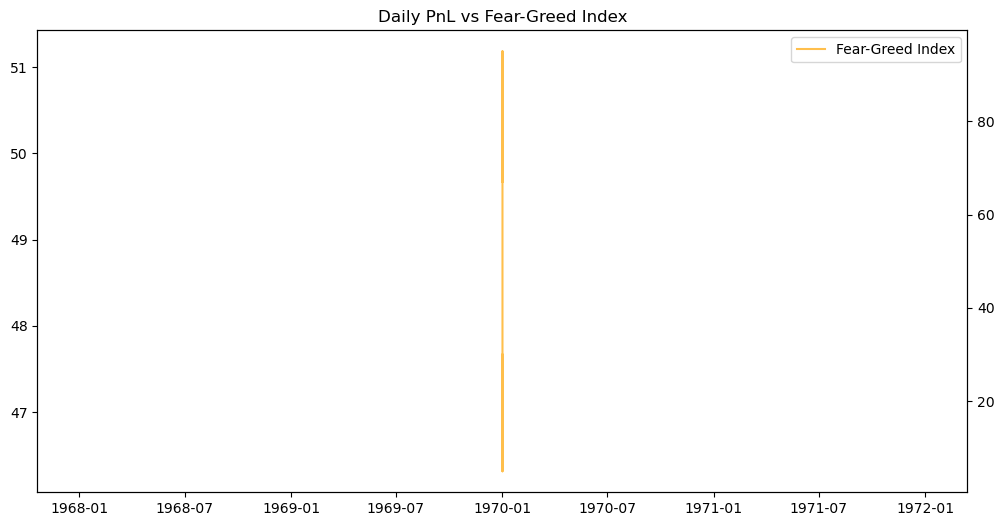

<Figure size 800x500 with 0 Axes>

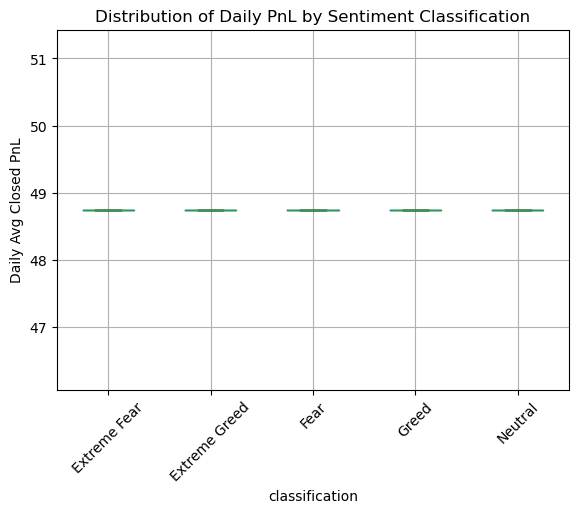

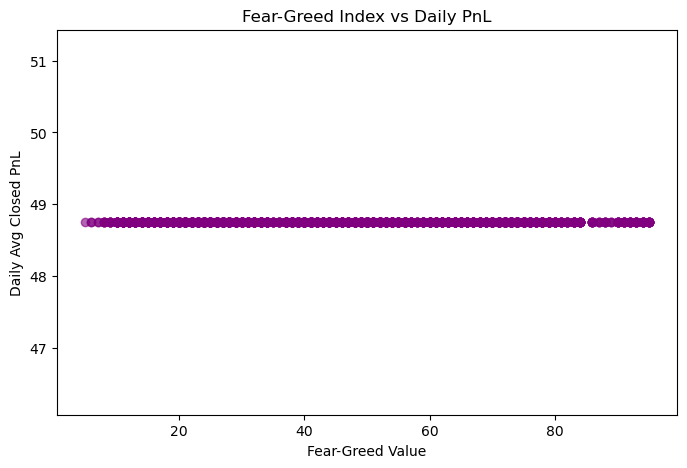

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Define key columns ---
col_pnl = "Closed PnL"
col_time = "Timestamp"

col_fg_time = "fg_date"
col_fg_value = "fg_value"
col_fg_class = "classification"

# --- Step 2: Prepare Daily PnL ---
hist[col_time] = pd.to_datetime(hist[col_time], errors='coerce')
daily_pnl = (
    hist.groupby(hist[col_time].dt.date)[col_pnl]
    .mean()
    .reset_index()
    .rename(columns={col_time: "trade_date", col_pnl: "closedpnl_mean"})
)

# Convert to datetime.date properly
daily_pnl["trade_date"] = pd.to_datetime(daily_pnl["trade_date"])

# --- Step 3: Prepare Fear-Greed Index ---
fg[col_fg_time] = pd.to_datetime(fg[col_fg_time], errors='coerce')
fg = fg[[col_fg_time, col_fg_value, col_fg_class]].dropna()
fg = fg.rename(columns={
    col_fg_time: "fg_date",
    col_fg_value: "fg_value",
    col_fg_class: "classification"
})
fg["fg_date"] = pd.to_datetime(fg["fg_date"])

# --- Step 4: Merge datasets (now both are datetime) ---
merged = pd.merge(
    daily_pnl,
    fg,
    left_on="trade_date",
    right_on="fg_date",
    how="inner"
)

# --- Step 5: Visualization 1 - Time series of PnL & Fear-Greed ---
plt.figure(figsize=(12,6))
plt.plot(merged["trade_date"], merged["closedpnl_mean"], label="Daily Avg PnL", color="blue")
plt.twinx()
plt.plot(merged["trade_date"], merged["fg_value"], label="Fear-Greed Index", color="orange", alpha=0.7)
plt.title("Daily PnL vs Fear-Greed Index")
plt.xlabel("Date")
plt.legend(loc="best")
plt.show()

# --- Step 6: Visualization 2 - Boxplot of PnL by sentiment ---
plt.figure(figsize=(8,5))
merged.boxplot(column="closedpnl_mean", by="classification", rot=45)
plt.title("Distribution of Daily PnL by Sentiment Classification")
plt.suptitle("")
plt.ylabel("Daily Avg Closed PnL")
plt.show()

# --- Step 7: Visualization 3 - Scatterplot ---
plt.figure(figsize=(8,5))
plt.scatter(merged["fg_value"], merged["closedpnl_mean"], alpha=0.6, c="purple")
plt.title("Fear-Greed Index vs Daily PnL")
plt.xlabel("Fear-Greed Value")
plt.ylabel("Daily Avg Closed PnL")
plt.show()


In [57]:

if 'classification' in merged.columns and 'closedpnl_mean' in merged.columns:
    desc = merged.groupby('classification')['closedpnl_mean'].agg(['count','mean','median']).reset_index()
    desc.to_csv(os.path.join(OUT_DIR,'descriptive_by_sentiment.csv'), index=False)


# Kruskal-Wallis test
groups = [group.dropna().values 
          for name, group in merged.dropna(subset=['classification','closedpnl_mean']).groupby('classification')['closedpnl_mean']]

# Only run Kruskal-Wallis if there is variability
if len(groups) >= 2 and all([len(np.unique(g)) > 1 for g in groups]):
    try:
        kw = stats.kruskal(*groups)
        with open(os.path.join(OUT_DIR,'kruskal_results.txt'),'w') as f:
            f.write(f'Kruskal-Wallis statistic: {kw.statistic}\n')
            f.write(f'p-value: {kw.pvalue}\n')
        print('Kruskal-Wallis p-value:', kw.pvalue)
    except Exception as e:
        print('Error running Kruskal:', e)
else:
    print("Skipping Kruskal-Wallis: groups are identical or lack variation.")

#) Wrap-up and saved files

print('All outputs saved to', OUT_DIR)
print('Files:', os.listdir(OUT_DIR))


Skipping Kruskal-Wallis: groups are identical or lack variation.
All outputs saved to /mnt/data/trader_sentiment_outputs
Files: ['daily_merged_metrics.csv', 'descriptive_by_sentiment.csv', 'event_study.csv', 'timeseries_closedpnl_fg.png']
